# import

In [1]:
from scipy.spatial import distance
from scipy.stats import gaussian_kde
import seaborn as sns
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import networkx as nx
import hypernetx as hnx
import itertools
import pandas as pd
import matplotlib.cm as cm
import pickle
import numpy as np
import copy
import cdlib
import collections

from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment

import matplotlib.lines as lines
import matplotlib.patches as patches

from adjustText import adjust_text
import random
import re
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import rankdata


In [102]:


def loadPickle(folder, file):
    with open(folder + file, 'rb') as handle:
        val = pickle.load(handle)
    return val
def savePickle(val, folder, file):
    with open(folder + file, 'wb') as handle:
        pickle.dump(val, handle, protocol=pickle.HIGHEST_PROTOCOL)

dir = "/home/liu/43_Gene2Role/Gene2role/data/curated/"
dir_emb = "/home/liu/43_Gene2Role/Gene2role/emb/curated/"
filelist = ['mcad', 'vsc', 'hsc', 'gsd']
outputDIR = '/home/liu/43_Gene2Role/Gene2role/figs/'
DICT_method2emb = { 'Gene2Role':'.emb',
                    'struc2vec':'_graph_struc2vec.emb',
                    # 'GraphWave':'_weighted_graphwave.emb',
                    'deepwalk':'_deepwalk.emb',
                    'node2vec':'_graph_node2vec.emb',
                    # 'walklets':'_weighted_walklets.emb',
                    'LINE':'_g2r_line.emb',
                    # 'hpe':'_weighted_hpe.emb',
                    # 'app':'_weighted_app.emb',
                    # 'mf':'_weighted_mf.emb',
                    # 'bpr':'_weighted_bpr.emb',
                    # 'warp':'_weighted_warp.emb',
                    'BESIDE':'_g2r_beside_beside.emb.ep90',
}
DICT_method2dir = { 'Gene2Role':'/home/liu/43_Gene2Role/Gene2role/emb/curated/',
                    'struc2vec':'/home/liu/01_lib/struc2vec/emb/curated/',
                    # 'GraphWave':'/home/liu/01_lib/graphwave/emb/',
                    'deepwalk':'/home/liu/43_Gene2Role/Gene2role/emb/curated/',
                    'node2vec':'/home/liu/43_Gene2Role/Gene2role/emb/curated/',
                    # 'walklets':'/home/liu/01_lib/smore/emb/',
                    'LINE':'/home/liu/01_lib/smore/emb/',
                    # 'hpe':'/home/liu/01_lib/smore/emb/',
                    # 'app':'/home/liu/01_lib/smore/emb/',
                    # 'mf':'/home/liu/01_lib/smore/emb/',
                    # 'bpr':'/home/liu/01_lib/smore/emb/',
                    # 'warp':'/home/liu/01_lib/smore/emb/',
                    'BESIDE':'/home/liu/01_lib/BESIDE/emb/',
}


# curated

## read file

In [117]:
dict_graph = {}
node_color_dict = {
    'mcad':{'Sp8':0, 'Emx2':1, 'Coup':1, 'Fgf8':2, 'Pax6':2},
    'vsc':{'Dbx1':1, 'Nkx62':1},
    'hsc':{'Fli1':1, 'Eklf':1, 'cJun':2, 'EgrNab':2},
    'gsd':{'DHH':1, 'PGD2':1},
}
for x in filelist:
    df = pd.read_csv(dir + x+'.edgelist', sep='\t', header=None).rename(columns={2:'sign'})
    g = nx.from_pandas_edgelist(df, 0, 1, edge_attr=['sign'])
    pos = nx.spring_layout(g, k=0.2, seed=2024)
    # g = nx.read_edgelist(dir + filelist[0]+'.edgelist', delimiter='\t', nodetype=int)
    df_name = pd.read_csv(dir + x+'_index.txt', sep='\t', header=None)
    df_name['color'] = df_name[0].map(node_color_dict[x]).fillna(0).astype(int)
    nx.set_node_attributes(g, dict(zip(df_name[1], df_name['color'])), 'color')

    dict_graph[x] = {'g':g, 'pos':pos, 'df_name':df_name}

## all

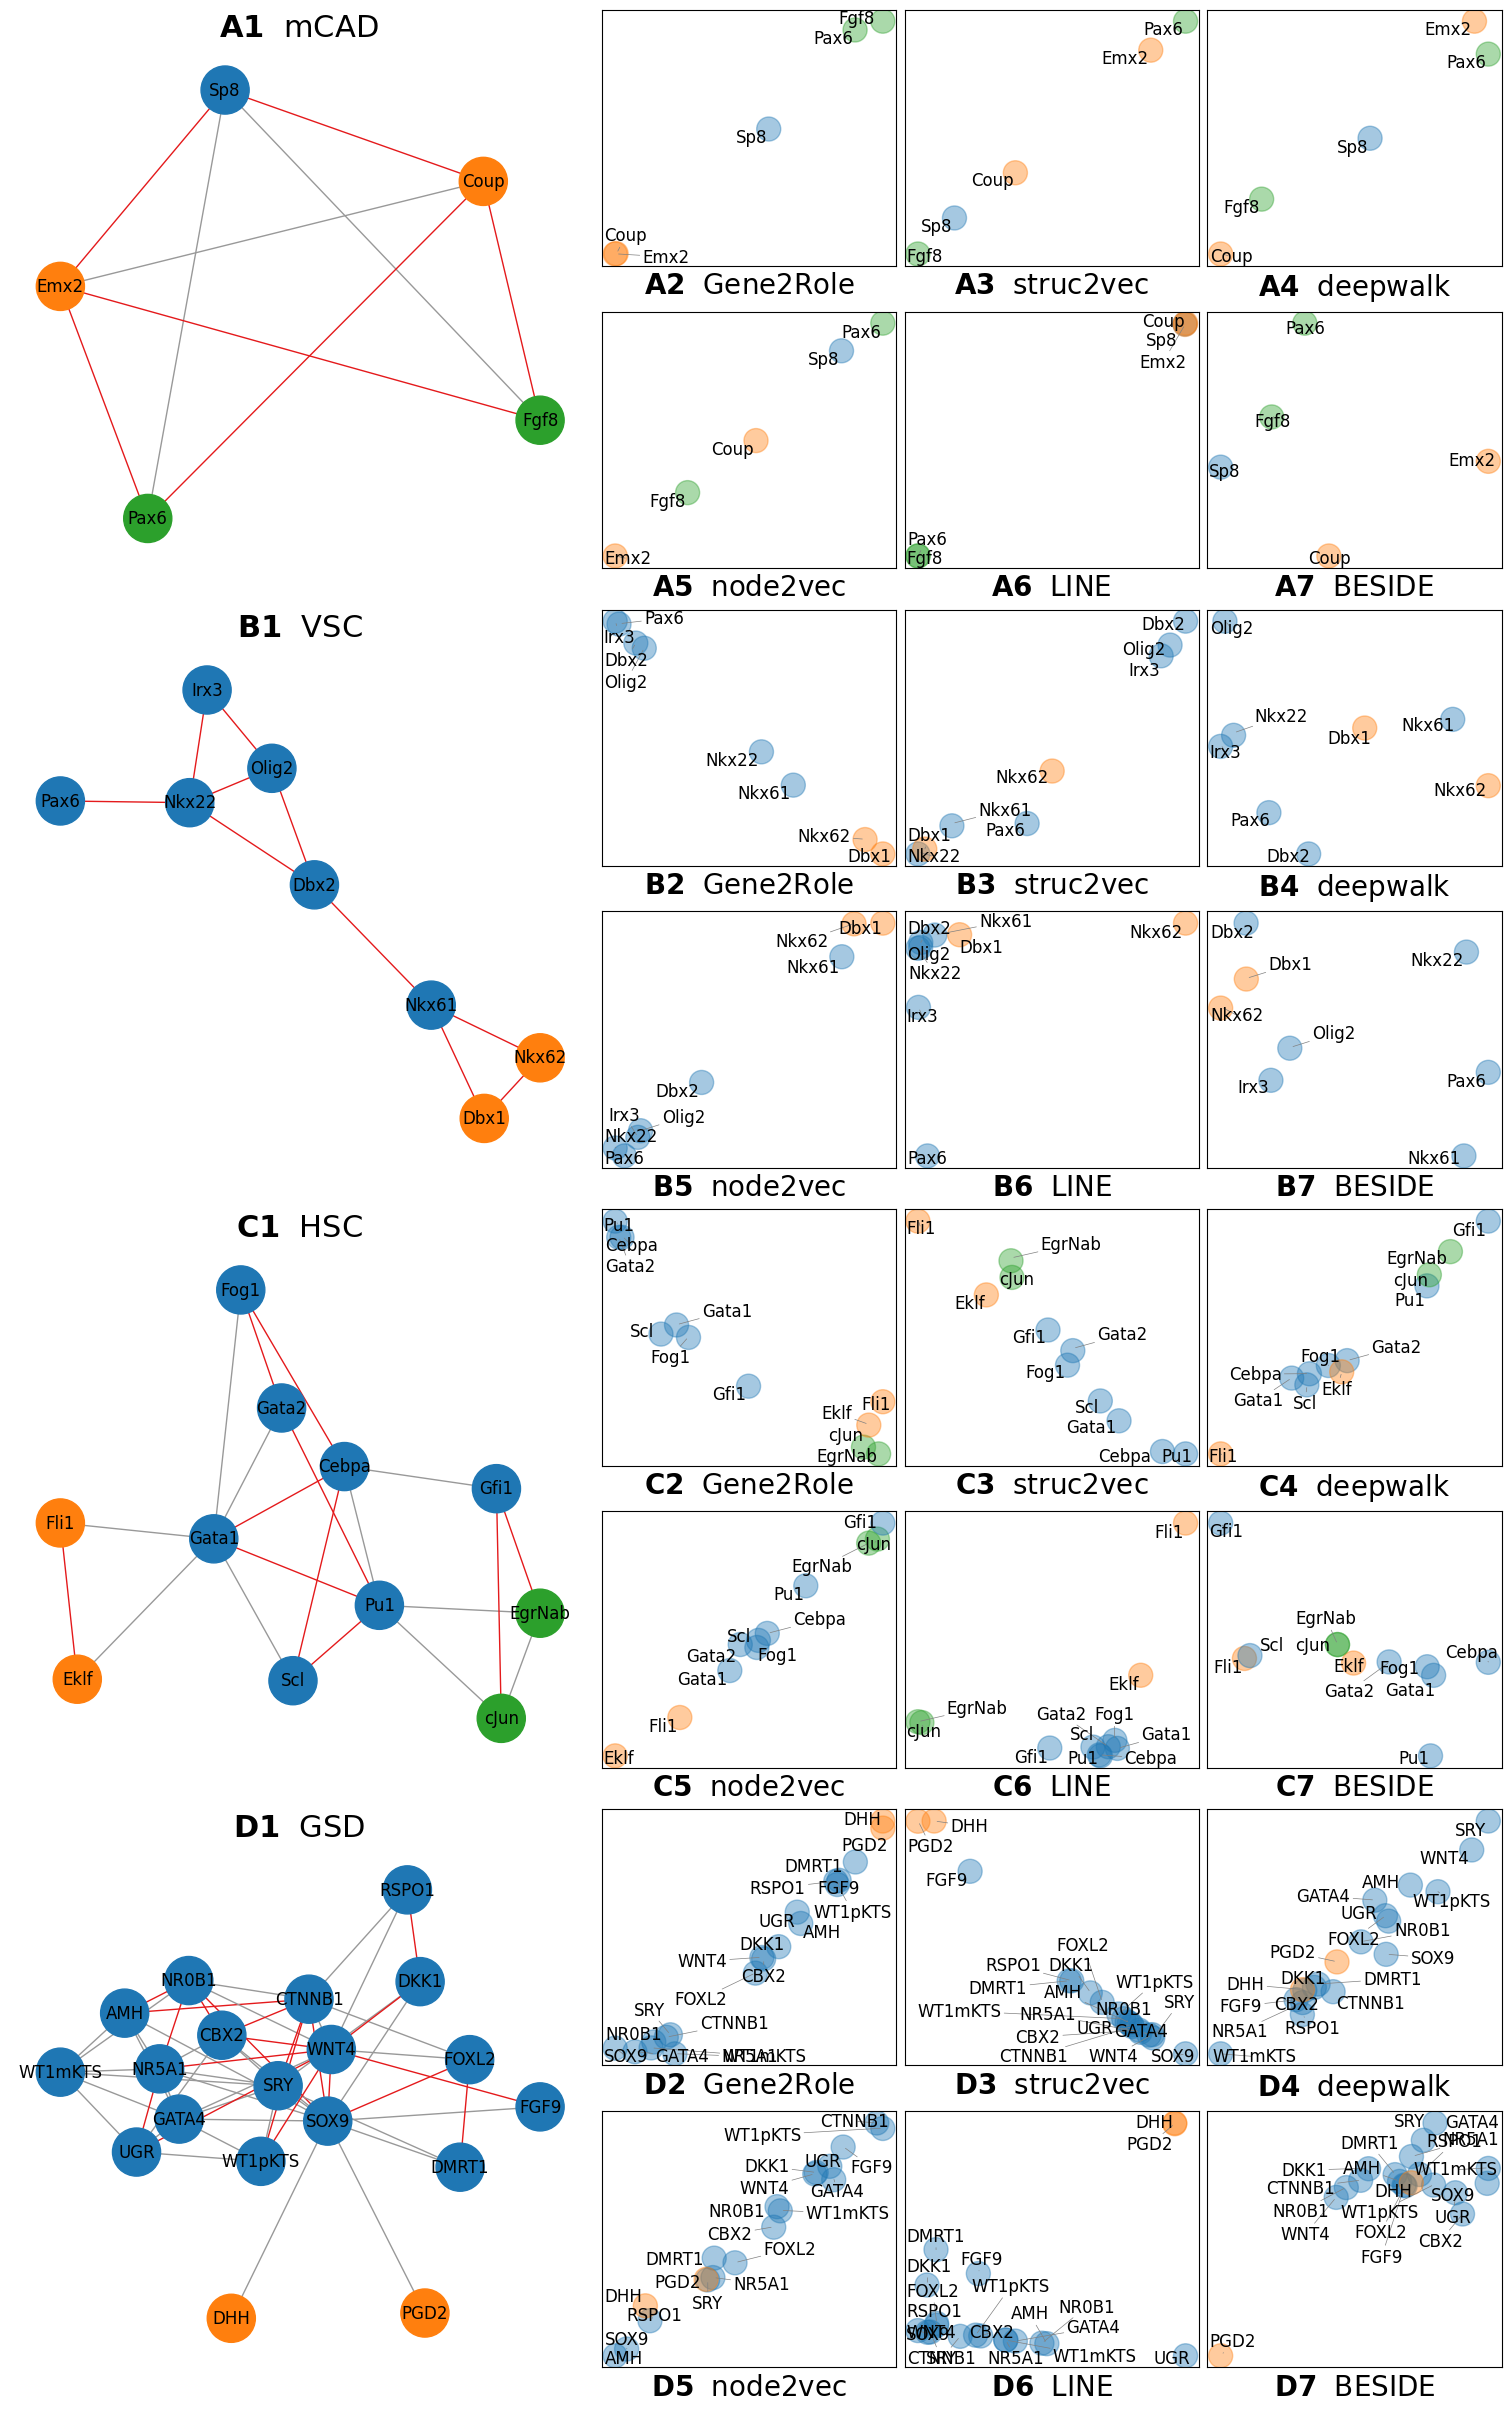

In [119]:
bias=0.001
lim_time=1

fig, axs = plt.subplots(2*len(dict_graph),5, layout='constrained', figsize=(15, 6*len(dict_graph)))
gridspec = axs[0,0].get_subplotspec().get_gridspec()
for a in axs[:,:2].flat:
    a.remove()
dict_number_p = dict(zip(dict_graph.keys(), ['A', 'B', 'C', 'D', 'E', 'F', 'G']))
dict_name_p = {'mcad':'mCAD', 'vsc':'VSC', 'hsc':'HSC', 'gsd':'GSD'}
for ix,x in enumerate(dict_graph.keys()):
# for project in ['Rcircle']:
    # weighted network
    subfig = fig.add_subfigure(gridspec[ix*2:ix*2+2,:2])
    axsLeft = subfig.subplots(1,1)
    nx.draw_networkx(dict_graph[x]['g'], dict_graph[x]['pos'], with_labels=False, 
                node_size=1200,
        # font_size=22,
        node_color=[cm.tab10(nx.get_node_attributes(dict_graph[x]['g'],'color')[n]) for n in dict_graph[x]['g'].nodes],
        # width=[weight_map[x] if x in weight_map else 1 for x in g.edges ],
        edge_color=[cm.Set1(nx.get_edge_attributes(dict_graph[x]['g'], 'sign')[e]/2+0.5) for e in dict_graph[x]['g'].edges],
    )
    nx.draw_networkx_labels(dict_graph[x]['g'], dict_graph[x]['pos'], labels=dict(zip(dict_graph[x]['df_name'][1], dict_graph[x]['df_name'][0])))
    ax=plt.gca()
    ax.set_axis_off()
    plt.title(r'$\bf{'+dict_number_p[x]+'1}$  '+dict_name_p[x]+' ', fontsize=22)
    
    cnt = -1
    for method in DICT_method2emb.keys():
        # print (method)
        cnt += 1
        # gene2role
        plt.sca(axs[ix*2 + cnt//3, cnt%3 + 2])
        try:
            if method != 'BESIDE':
                df = pd.read_csv(DICT_method2dir[method] + x + DICT_method2emb[method], sep=' ',skiprows=1 ,header=None)
                df = df.sort_values(by=0).reset_index(drop=True)
            else:
                df = loadPickle(DICT_method2dir[method], x + DICT_method2emb[method])[1][0][1:]
                df = pd.DataFrame(df).reset_index().rename(columns={'index':0, 0:1, 1:2}).drop(0, axis=0).reset_index(drop=True)
            # print (df)
            plt.scatter(df[1],df[2],c=[cm.tab10(dict_graph[x]['g'].nodes(data='color')[n]) for n in df[0]], s=300,alpha=0.4)
            ax = plt.gca()
            texts = []
            for n in range(df.shape[0]):
                plt_text = ax.annotate(dict(zip(dict_graph[x]['df_name'][1], dict_graph[x]['df_name'][0]))[df.loc[n,0]], (df.loc[n,1]+ random.random()* bias, df.loc[n,2]+ random.random()* bias), fontsize=12)
                texts.append(plt_text)

            adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), min_arrow_len=10, time_lim = lim_time)
            # ax.set_axis_off()
            ax.axes.xaxis.set_ticks([])
            ax.axes.yaxis.set_ticks([])
        except FileNotFoundError:
            pass
        # plt.title(r'$\bf{'+dict_number_p[project]+'3}$  '+'HyperS2V', fontsize=20)
        plt.xlabel(r'$\bf{'+dict_number_p[x]+str(cnt+2)+'}$  '+ method, fontsize=20)

plt.savefig(outputDIR+'WHOLE_curated_all.pdf',dpi=500, bbox_inches='tight')

## individual

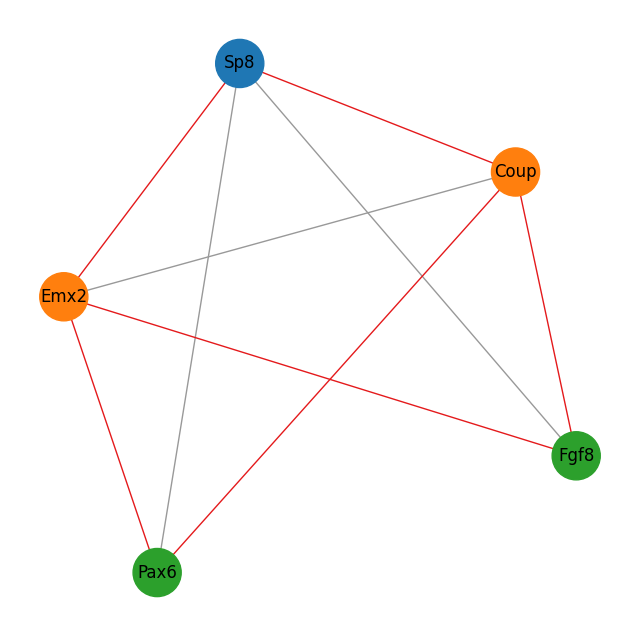

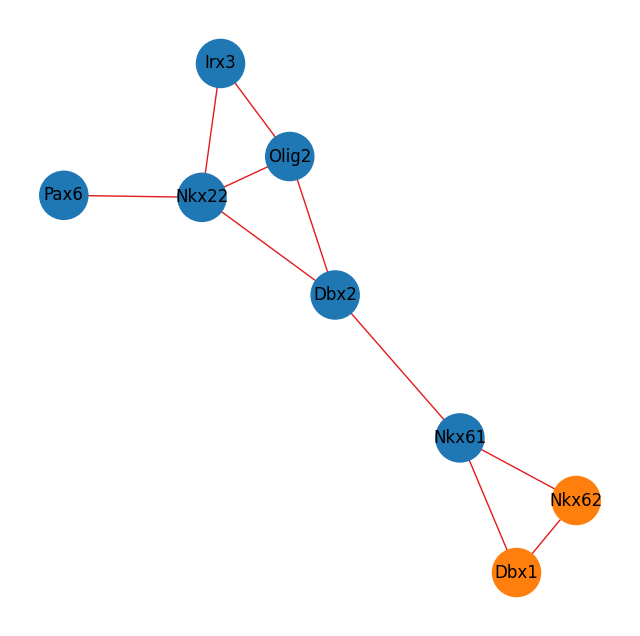

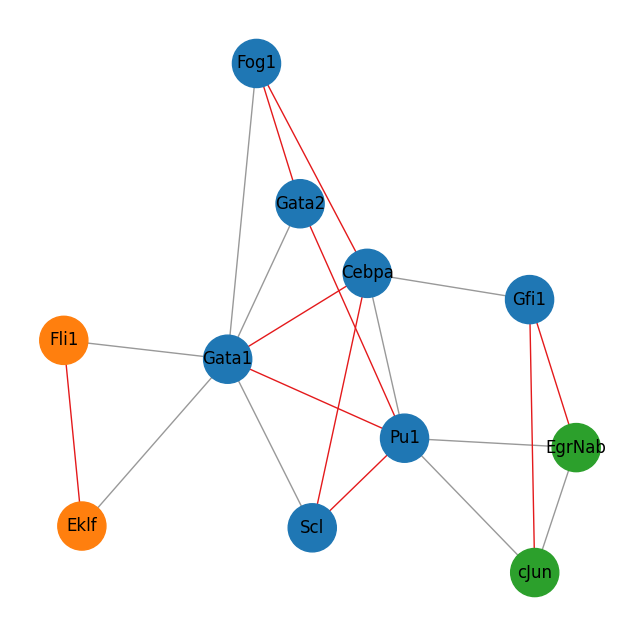

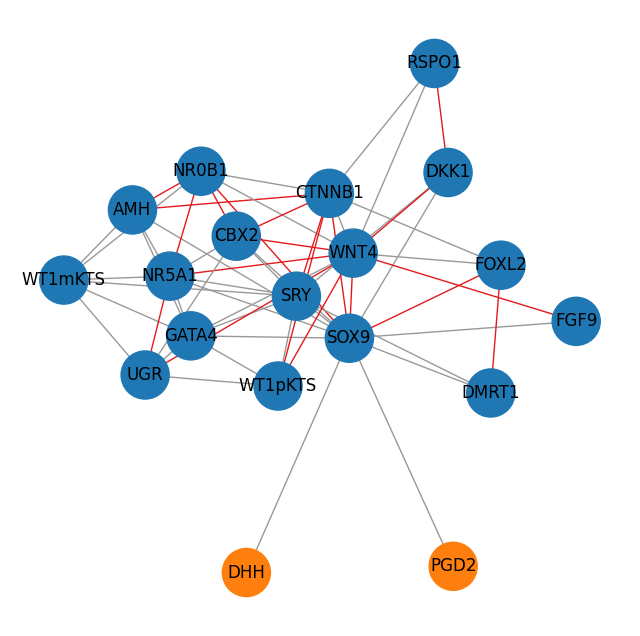

In [118]:
for x in filelist:
    nx.draw_networkx(dict_graph[x]['g'], dict_graph[x]['pos'], with_labels=False, 
                    node_size=1200,
            # font_size=22,
            node_color=[cm.tab10(nx.get_node_attributes(dict_graph[x]['g'],'color')[n]) for n in dict_graph[x]['g'].nodes],
            # width=[weight_map[x] if x in weight_map else 1 for x in g.edges ],
            edge_color=[cm.Set1(nx.get_edge_attributes(dict_graph[x]['g'], 'sign')[e]/2+0.5) for e in dict_graph[x]['g'].edges],
        )
    nx.draw_networkx_labels(dict_graph[x]['g'], dict_graph[x]['pos'], labels=dict(zip(dict_graph[x]['df_name'][1], dict_graph[x]['df_name'][0])))
    ax=plt.gca()
    ax.set_axis_off()
    plt.show()

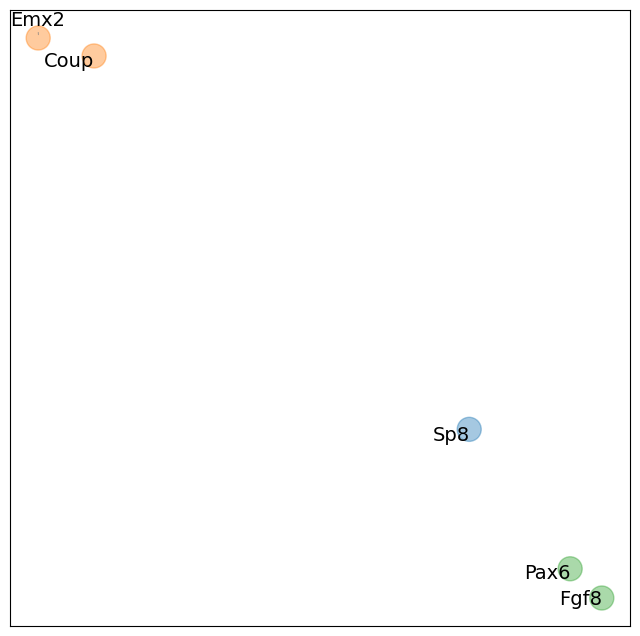

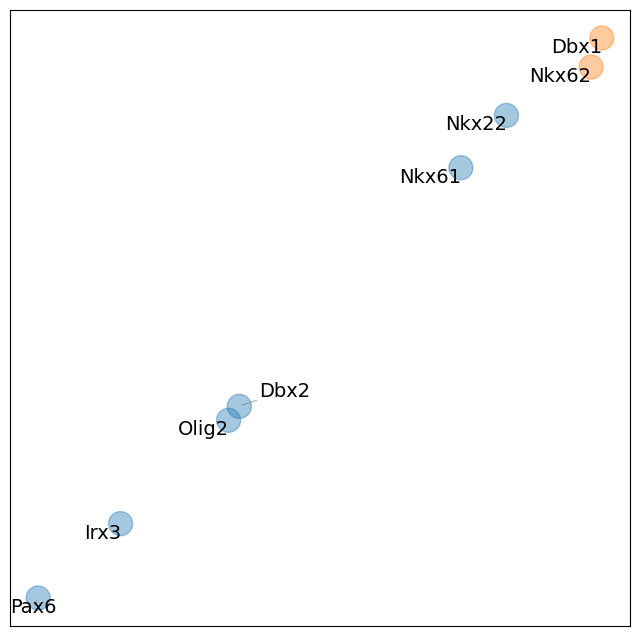

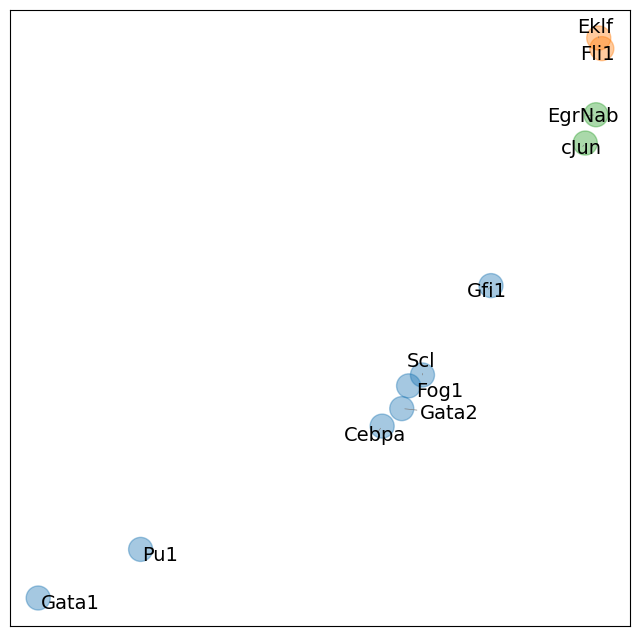

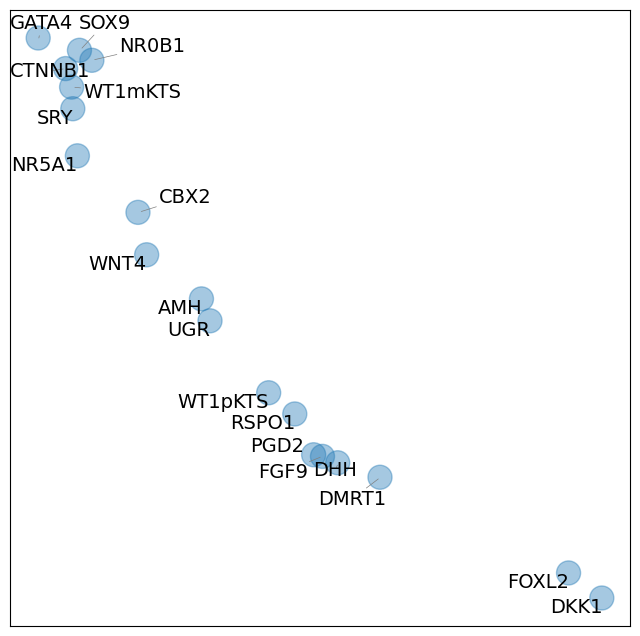

In [88]:
bias=0.001
lim_time=1

for x in filelist:
# x = 'mcad'
    # plt.sca(axs[ix*2,4])
    df = pd.read_csv(dir_emb + x +'.emb', sep=' ',skiprows=1 ,header=None)
    df = df.sort_values(by=0).reset_index(drop=True)

    plt.scatter(df[1],df[2],c=[cm.tab10(dict_graph[x]['g'].nodes(data='color')[n]) for n in df[0]], s=300,alpha=0.4)
    ax = plt.gca()
    texts = []
    for n in range(df.shape[0]):
        plt_text = ax.annotate(dict(zip(dict_graph[x]['df_name'][1], dict_graph[x]['df_name'][0]))[df.loc[n,0]], (df.loc[n,1]+ random.random()* bias, df.loc[n,2]+ random.random()* bias), fontsize=14)
        texts.append(plt_text)

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), min_arrow_len=10, time_lim = lim_time)
    # ax.set_axis_off()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    # # plt.title(r'$\bf{'+dict_number_p[project]+'3}$  '+'HyperS2V', fontsize=20)
    plt.show()



## trash